<a href="https://colab.research.google.com/github/stevearonson/VB-Video-Tracking/blob/master/Detectron2_with_DeepSort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Detectron2

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [3]:
import numpy as np
import pandas as pd
import random

import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# from detectron2.utils.logger import setup_logger
# setup_logger()

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer

import os


## Access My Google Drive

In [11]:
from google.colab import drive
drive.mount('/gdrive')
base_dir = '/gdrive/My Drive/VB/Video'
!ls '/gdrive/My Drive/VB/Video'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
 ball_tracker.mp4	     court-diagram-vertical.jpg   panopt.mp4
 Cheshire_Halasz_Perin	     demo.avi			  people.mp4
 Cheshire_Halasz_Perin.pdf   image			  player_pos.csv
 Cheshire_Halasz_Perin.zip  'MBVF M7 S3.mp4'		  tracker.mp4
'CHVC M6 S3.mp4'	     model_final.pth		  tracker_trails.jpg
 ckpt.t7		     new_images			  video-clip.mp4
 court-diagram.jpg	     OpenCV.ipynb		  voc2coco.py


##Install DeepSort

In [5]:
!git clone --recurse-submodules https://github.com/sayef/detectron2-deepsort-pytorch.git
!mv detectron2-deepsort-pytorch detectron2_deepsort_pytorch
!cp '/gdrive/My Drive/VB/Video/ckpt.t7' detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/

from detectron2_deepsort_pytorch.deep_sort import DeepSort
from detectron2_deepsort_pytorch.util import draw_bboxes

Cloning into 'detectron2-deepsort-pytorch'...
remote: Enumerating objects: 374, done.
remote: Total 374 (delta 0), reused 0 (delta 0), pack-reused 374
Receiving objects: 100% (374/374), 18.97 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (183/183), done.
Submodule 'detectron2' (https://github.com/facebookresearch/detectron2.git) registered for path 'detectron2'
Cloning into '/content/detectron2-deepsort-pytorch/detectron2'...
remote: Enumerating objects: 5, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing objects: 100% (5/5), done.        
remote: Total 6218 (delta 0), reused 1 (delta 0), pack-reused 6213        
Receiving objects: 100% (6218/6218), 2.82 MiB | 13.55 MiB/s, done.
Resolving deltas: 100% (4508/4508), done.
Submodule path 'detectron2': checked out 'eef3ab14c0777da7114e25689c703bb5d6094737'
mv: cannot move 'detectron2-deepsort-pytorch' to 'detectron2_deepsort_pytorch/detectron2-deepsort-pytorch': Directory not empty


## Run the Detectron2-DeepSort Demo

In [ ]:
%cd detectron2_deepsort_pytorch
!python demo_detectron2_deepsort.py '/gdrive/My Drive/VB/Video/video-clip.mp4' --ignore_display
!cp demo.avi '/gdrive/My Drive/VB/Video'

# Combining Detectron2 with DeepSort

Flow of video processing:

1. Iterate over video frames
2. Detect objects in frame
3. Identify players (people) inside court playing area
4. Move player detection data into deep sort data structure
5. Update deepsort algorithm
6. Draw bbox on original frame
7. Map bbox to player location on court diagram
8. Insert court diagram into original frame
9. Write new frame to output video file

## Create a detection class using Detectron2

In [27]:
from detectron2.data.datasets import register_coco_instances
# register_coco_instances("volleyball", {}, base_dir + '/image/output.json', base_dir + '/image')

class Detectron2:

    def __init__(self, use_custom_model = False):
        self.use_custom_model = use_custom_model
        self.cfg = get_cfg()

        if use_custom_model:
            self.ball_metadata = MetadataCatalog.get("volleyball")
            self.dataset_dicts = DatasetCatalog.get("volleyball")
            self.cfg.DATASETS.TEST = ("volleyball", )
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
            self.cfg.MODEL.WEIGHTS = base_dir + '/model_final.pth'
            self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(self.ball_metadata.get('thing_classes'))

            ball_metadata = MetadataCatalog.get("volleyball")
            self.tags = np.array(self.ball_metadata.get('thing_classes'))

        else:
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
            
        self.predictor = DefaultPredictor(self.cfg)

    def detect(self, im):
        outputs = self.predictor(im)
        boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        classes = outputs["instances"].pred_classes.cpu().numpy()
        scores = outputs["instances"].scores.cpu().numpy()

        bbox_xcycwh, cls_conf, cls_ids = [], [], []

        for (box, _class, score) in zip(boxes, classes, scores):

#            if _class == 0:
            x0, y0, x1, y1 = box
            bbox_xcycwh.append([(x1 + x0) / 2, (y1 + y0) / 2, (x1 - x0), (y1 - y0)])
            cls_conf.append(score)
            cls_ids.append(_class)

        return np.array(bbox_xcycwh, dtype=np.float64), np.array(cls_conf), np.array(cls_ids)


In [26]:
len(ball_metadata.get('thing_classes'))

12

## Create class for handling court geometries

In [17]:
from shapely.geometry import Point, Polygon

class Court:
    def __init__(self):

        self.video_court = np.array([[[467, 249], [781, 242], 
                                      [1274, 588], [630, 656], [3, 619]]])
        self.video_playing = Polygon(np.array([[426, 235], [824, 230], 
                                               [1272, 512], [1253, 714], 
                                               [9, 713], [15, 470]]))
        self.diagram_court = np.array([[[100, 100], [400, 100], [400, 700], 
                                        [250, 700], [100, 700]]])
        self.M = cv2.findHomography(self.video_court, self.diagram_court)[0]

        self.court_diagram_file = '/gdrive/My Drive/VB/Video/court-diagram-vertical.jpg'

        # defaults for drawing on video frames
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.fontScale = 1

        self.radius = 10
        self.color = [255, 0, 0]   
        self.thickness = 2


    def draw_court(self, frame):
         return cv2.polylines(frame, [self.video_court], isClosed=True, 
                              color=self.color, thickness=self.thickness)


    def in_playing_area(self, bbox_xcycwh):
        xc, yc, w, h = bbox_xcycwh
        player_pos = (xc, yc + h/2)
        return Point(player_pos).within(self.video_playing)


    def map_pos_to_diagram(self, player_positions):
        src_pts = np.array([player_positions.astype('float32')])
        dst_pts = cv2.perspectiveTransform(src_pts, self.M)
        return dst_pts.squeeze().astype('int')


    def create_mini_map(self, court_positions, identities):
        # player marker parameters
        court_diagram = cv2.imread(self.court_diagram_file)

        for pt, tag in zip(court_positions, identities):
            # cv2.circle(court_diagram, tuple(pt), self.radius, 
            #           self.color, self.thickness)
            cv2.putText(court_diagram, str(tag), tuple(pt), self.font, self.fontScale, 
                        self.color, self.thickness, cv2.LINE_AA)

        mini_map = cv2.resize(court_diagram, (250, 400), interpolation = cv2.INTER_AREA)
        return mini_map

## Main Loop

In [18]:
# create a time log for rallys in video
time_log = pd.DataFrame({'Rally': [1,2,3,4], 
                         'Start': pd.to_timedelta(['00:00:11', '00:00:33', '00:00:52','00:01:18']),
                         'Length': pd.to_timedelta(['00:00:06', '00:00:08', '00:00:14','00:00:11']),
                         'P1' : ['Sophia', 'Emily', 'Emily', 'Emily'],
                         'P2' : ['Emily', 'Maggie', 'Maggie', 'Maggie'],
                         'P3' : ['Maggie', 'Taylor', 'Taylor', 'Taylor'],
                         'P4' : ['Taylor', 'Quinn', 'Quinn', 'Quinn'],
                         'P5' : ['Quinn', 'Cici', 'Cici', 'Cici'],
                         'P6' : ['Cici', 'Sophia', 'Sophia', 'Sophia']
                         })

In [28]:
cap = cv2.VideoCapture('/gdrive/My Drive/VB/Video/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter('/gdrive/My Drive/VB/Video/tracker.mp4', fourcc,
                           frames_per_second, (width, height))
use_custom_model = True
detectron2 = Detectron2(use_custom_model=use_custom_model)
deepsort = DeepSort('detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7', use_cuda=True)
court = Court()

video_time = 0
all_pos = []

for _,rally in time_log.iterrows():

    # skip to beginning of rally
    skip_frames = int((rally['Start'].seconds - video_time) * frames_per_second)
    for ix in range(skip_frames):
        ret, frame = cap.read()
        videoOut.write(frame)
    video_time = rally['Start'].seconds


    # process rally frames
    # first_rally_frame = True
    # deepsort = DeepSort('detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7', use_cuda=True)

    rally_frames = int(rally['Length'].seconds * frames_per_second)
    for ix in tqdm(range(rally_frames)):
        ret, frame = cap.read()
        bbox_xcycwh, cls_conf, cls_ids = detectron2.detect(frame)

        # add the court outline
        frame_poly = court.draw_court(frame)

        if use_custom_model:
            player_xcycwh = bbox_xcycwh
            player_conf = cls_conf

        else:
            # find detection indicies of players
            players_ix = [ix for ix, bbox in enumerate(bbox_xcycwh) if court.in_playing_area(bbox)]

            # limit detections to players
            player_xcycwh = bbox_xcycwh[players_ix, :]
            player_conf = cls_conf[players_ix]

        # update the deepsort model and collect tracker outputs
        if len(player_xcycwh) > 0:
#            outputs = deepsort.update(player_xcycwh, player_conf, frame)
#        else:
#            outputs = []

#        if len(outputs) > 0:
#            bbox_xyxy = outputs[:, :4]
#            identities = outputs[:, -1]

            bbox_xyxy = np.array([[xc-w/2, yc-h/2, xc+w/2, yc+h/2] for xc,yc,w,h in player_xcycwh])
            identities = cls_ids

            frame_poly = draw_bboxes(frame_poly, bbox_xyxy, identities)

            # create the min map
            identities = detectron2.tags[cls_ids]
            video_pos = np.array([[(x1+x2)/2, y2] for x1, y1, x2, y2 in bbox_xyxy])
            diagram_pos = court.map_pos_to_diagram(video_pos)
            if diagram_pos.ndim == 1:
                diagram_pos = diagram_pos[None, :]

            miniMap = court.create_mini_map(diagram_pos, identities)

            curr_pos = pd.DataFrame(np.concatenate([identities[:, None], diagram_pos], axis=1), 
                                    columns=['ID', 'X', 'Y'])
            curr_pos.insert(0, 'Rally', rally['Rally'])
            curr_pos.insert(1, 'Frame', ix)

            all_pos.append(curr_pos)


            #insert mini map into frame
            (w,h,c) = miniMap.shape
            frame_poly[0:w, 0:h, :] = miniMap

        videoOut.write(frame_poly)

    video_time += rally['Length'].seconds

videoOut.release()
cap.release()

WARNING [07/29 23:50:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/29 23:50:13 d2.data.datasets.coco]: Loaded 46 images in COCO format from /gdrive/My Drive/VB/Video/image/output.json
Loading weights from detectron2_deepsort_pytorch/deep_sort/deep/checkpoint/ckpt.t7... Done!


100%|██████████| 309/309 [02:02<00:00,  2.53it/s]


In [20]:
all_pos

[]

In [29]:
df = pd.concat(all_pos)
df.to_csv('/gdrive/My Drive/VB/Video/player_pos.csv', index=False)

## Custom Dataset Model Training

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("volleyball", {}, base_dir + '/image/output.json', base_dir + '/image')

In [7]:
ball_metadata = MetadataCatalog.get("volleyball")
dataset_dicts = DatasetCatalog.get("volleyball")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [8]:
ball_metadata

Metadata(evaluator_type='coco', image_root='/gdrive/My Drive/VB/Video/image', json_file='/gdrive/My Drive/VB/Video/image/output.json', name='volleyball', thing_classes=['Bella', 'Cici', 'Emily', 'Karoline', 'Kylie', 'Maggie', 'Mallory', 'Quinn', 'Shannon', 'Sophia', 'Taylor', 'volleyball'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11})

In [9]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("volleyball",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")   # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/29 21:51:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (13, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (13,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (48, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (48,) in the model! You might want to double check if this is expected.


[07/29 21:51:51 d2.engine.train_loop]: Starting training from iteration 0
[07/29 21:52:17 d2.utils.events]:  eta: 0:42:51  iter: 19  total_loss: 3.483  loss_cls: 2.492  loss_box_reg: 0.699  loss_rpn_cls: 0.239  loss_rpn_loc: 0.048  time: 1.3065  data_time: 0.0202  lr: 0.000020  max_mem: 2641M
[07/29 21:52:44 d2.utils.events]:  eta: 0:42:46  iter: 39  total_loss: 3.178  loss_cls: 2.211  loss_box_reg: 0.690  loss_rpn_cls: 0.203  loss_rpn_loc: 0.043  time: 1.3205  data_time: 0.0069  lr: 0.000040  max_mem: 2641M
[07/29 21:53:11 d2.utils.events]:  eta: 0:43:25  iter: 59  total_loss: 2.490  loss_cls: 1.613  loss_box_reg: 0.703  loss_rpn_cls: 0.122  loss_rpn_loc: 0.041  time: 1.3358  data_time: 0.0065  lr: 0.000060  max_mem: 2641M
[07/29 21:53:37 d2.utils.events]:  eta: 0:42:31  iter: 79  total_loss: 1.928  loss_cls: 1.022  loss_box_reg: 0.722  loss_rpn_cls: 0.109  loss_rpn_loc: 0.043  time: 1.3248  data_time: 0.0071  lr: 0.000080  max_mem: 2641M
[07/29 21:54:04 d2.utils.events]:  eta: 0:42:1

In [21]:
!ls -ls output

total 300
  4 -rw-r--r-- 1 root root     40 Jul 29 20:46 events.out.tfevents.1596055576.953626dba5e6.1027.0
 88 -rw-r--r-- 1 root root  85844 Jul 29 21:32 events.out.tfevents.1596055641.953626dba5e6.1027.1
 88 -rw-r--r-- 1 root root  85844 Jul 29 22:36 events.out.tfevents.1596059511.953626dba5e6.2683.0
  4 -rw-r--r-- 1 root root     15 Jul 29 22:36 last_checkpoint
116 -rw-r--r-- 1 root root 110738 Jul 29 22:36 metrics.json


In [14]:
# save trained model weights to video directoruy
!mv ./output/model_final.pth '/gdrive/My Drive/VB/Video'

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
# cfg.DATASETS.TRAIN = ("volleyball",)
cfg.DATASETS.TEST = ("volleyball", )
predictor = DefaultPredictor(cfg)

In [ ]:

cap = cv2.VideoCapture(base_dir + '/MBVF M7 S3.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
videoOut = cv2.VideoWriter(base_dir + '/ball_tracker.mp4', fourcc,
                           frames_per_second, (width, height))

thing_classes = ball_metadata.get('thing_classes')

v = VideoVisualizer(ball_metadata, ColorMode.IMAGE)
all_pos = []
for ix in tqdm(range(int(30 * frames_per_second))):
    ret, frame = cap.read()
    outputs = predictor(frame)

    pred_boxes = outputs["instances"].get('pred_boxes')
    pred_classes = outputs["instances"].get('pred_classes')
    if pred_boxes is None:
        pred_boxes = []

    pos = []
    for box, cls in zip(pred_boxes, pred_classes):
        cls_object = thing_classes[cls]
        xpos = int((box[0] + box[2]) / 2)
        if cls_object == 'volleyball':
            ypos = int(box[1] + box[3])
        else:
            ypos = int(box[3])

        pos.append({'Frame' : ix, 'ID' : cls_object, 'X': xpos, 'Y' : ypos})

    all_pos.extend(pos)

    out = v.draw_instance_predictions(frame, outputs["instances"].to("cpu")).get_image()
    videoOut.write(out)

videoOut.release()
cap.release()

100%|██████████| 843/843 [06:45<00:00,  2.08it/s]


[]

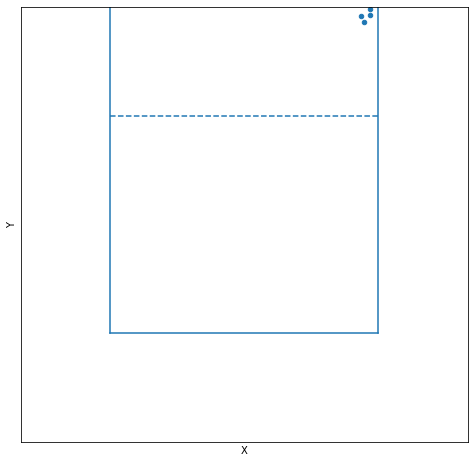

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

fig, axp = plt.subplots(figsize=(8,8))
axp.axis([0, 500, 400, 800])

df = pd.DataFrame(all_pos)
# df.plot('X', 'Y', kind='scatter', c='ID', cmap=cmap, edgecolor=None, ax=axp)
df[df['ID'] == 'Sophia'].plot('X', 'Y', kind='scatter', ax=axp)

axp.axhline(700, xmin=0.2, xmax=0.8)
axp.axhline(500, xmin=0.2, xmax=0.8, ls='dashed')
axp.axvline(100, ymin=0.25)
axp.axvline(400, ymin=0.25)
axp.invert_yaxis()

axp.get_xaxis().set_ticks([])
axp.get_yaxis().set_ticks([])


In [ ]:
[ball_metadata.get('thing_classes')[i] for i in outputs['instances'].get('pred_classes').cpu()]

['Taylor', 'Cici', 'Quinn', 'Quinn', 'Quinn']

In [ ]:
!ls -ls output

total 322688
    48 -rw-r--r-- 1 root root     42894 Jul 28 16:54 events.out.tfevents.1595953794.fb4d019e2b42.128.0
    48 -rw-r--r-- 1 root root     42894 Jul 28 17:20 events.out.tfevents.1595955371.fb4d019e2b42.128.1
     4 -rw-r--r-- 1 root root        15 Jul 28 17:20 last_checkpoint
    60 -rw-r--r-- 1 root root     55615 Jul 28 17:20 metrics.json
322528 -rw-r--r-- 1 root root 330264868 Jul 28 17:20 model_final.pth


In [ ]:
# register_coco_instances("volleyball", {}, base_dir + '/image/output.json', base_dir + '/image')
ball_metadata = MetadataCatalog.get("volleyball")
dataset_dicts = DatasetCatalog.get("volleyball")

cfg = get_cfg()
cfg.DATASETS.TEST = ("volleyball", )
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = base_dir + '/model_final.pth'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

predictor = DefaultPredictor(cfg)



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



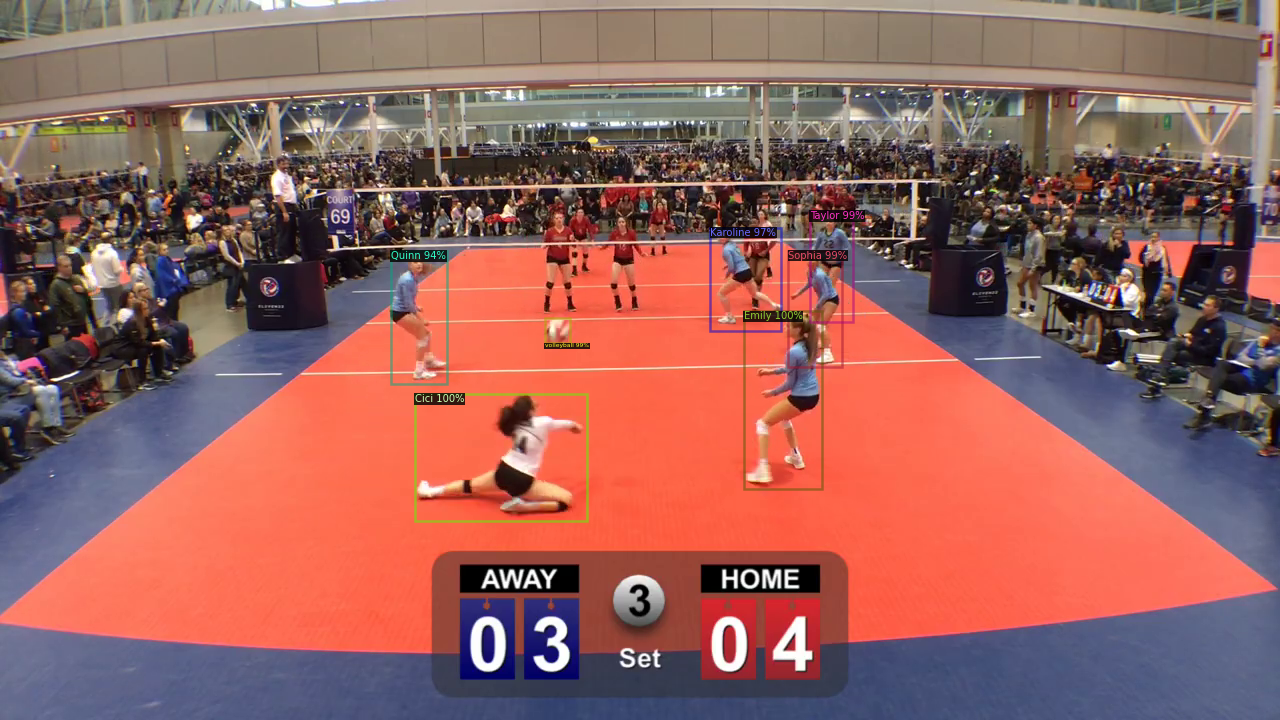

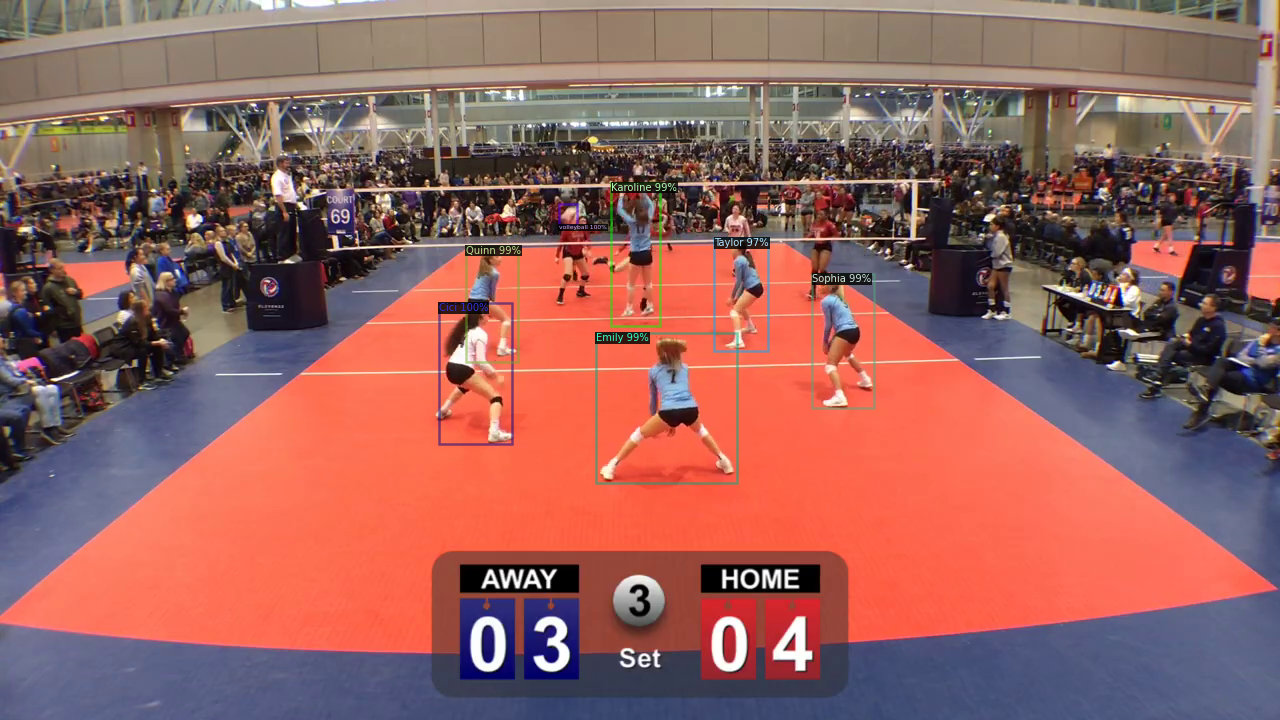

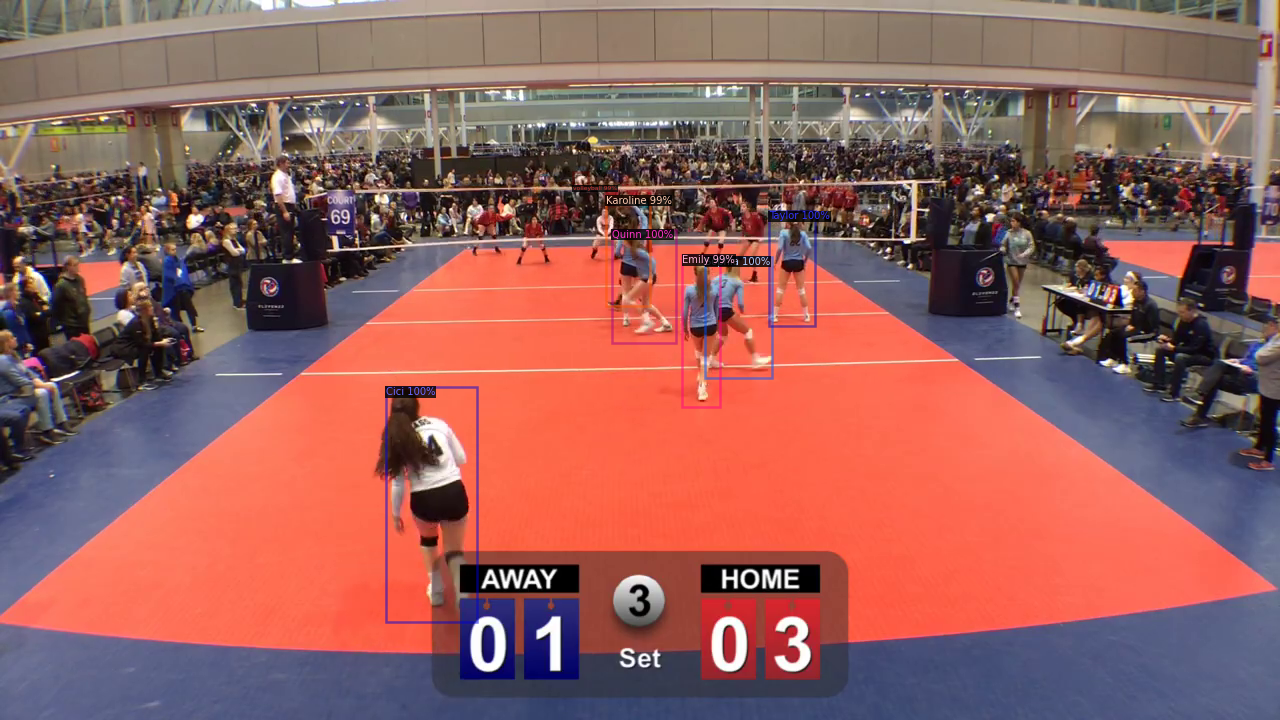

In [20]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=ball_metadata, scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])